# Extração de Características

Load

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

protocol = ['Flexão de punho', 'Extensão de punho', 'Pinça', 'Segurar cartão', 'Segurar caneta', 'Segurar esfera', 'Segurar copo', 'Gancho']

y = np.array([0,1,2,3,4,5,6,7] * 99)

voluntarios = dict()
for v in range(10):
    voluntarios[v] = np.load(f'./datasets/caract_{v}.npy')


### Visualização

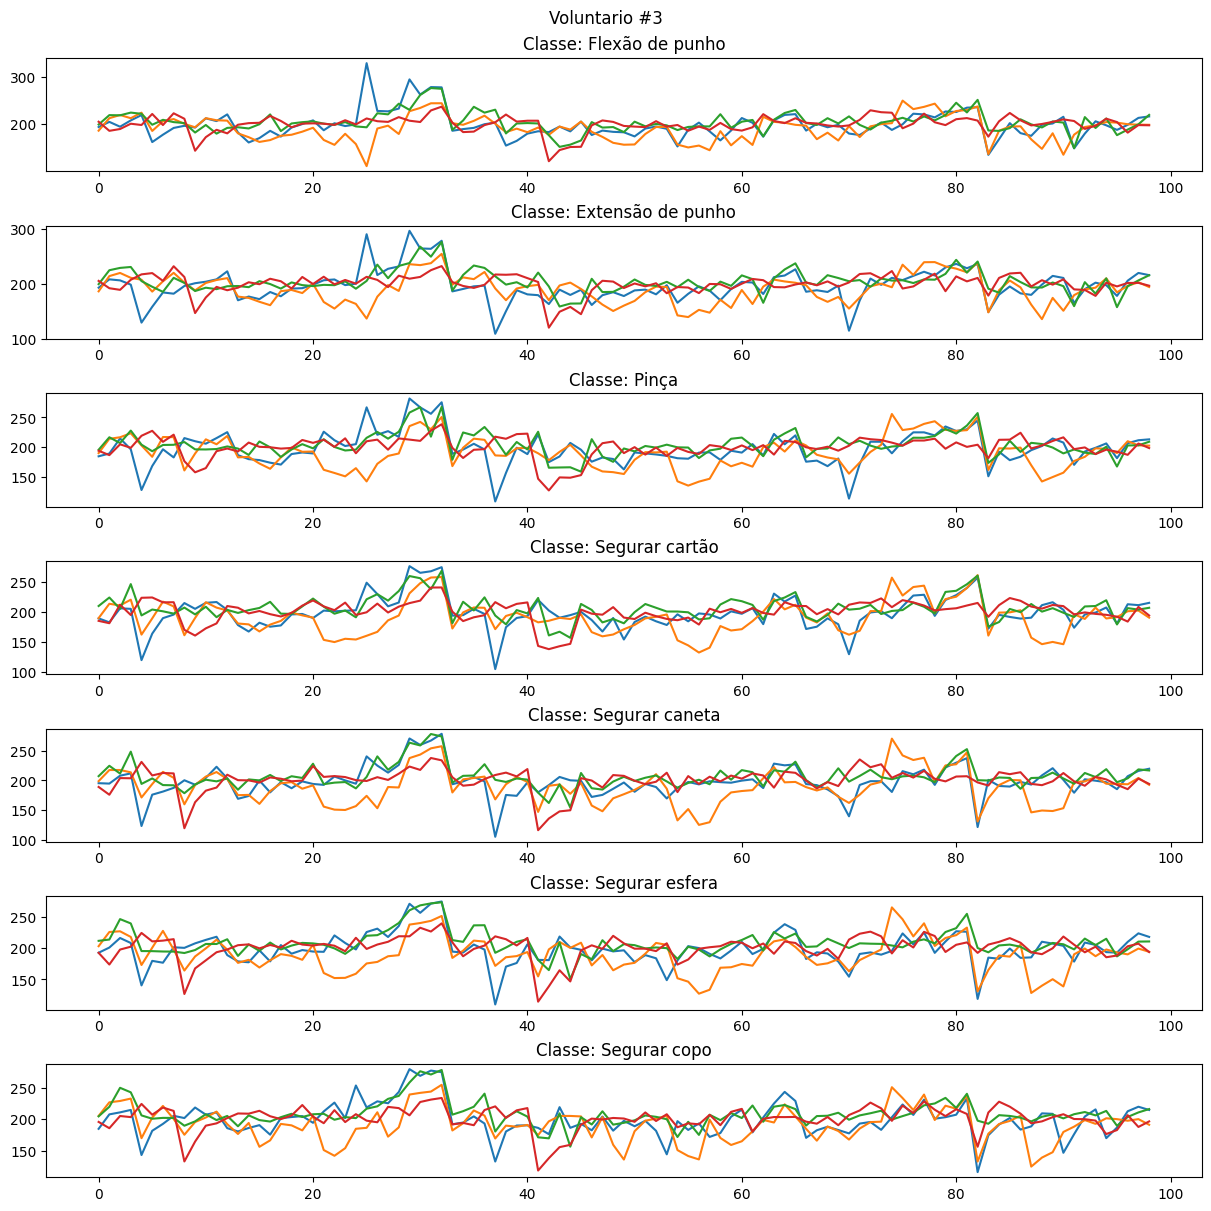

In [77]:
volN = 3
vol = voluntarios[volN]

subplts = 7
fig, ax = plt.subplots(subplts, 1, constrained_layout=True)
ax = ax if subplts > 1 else [ax]

rcParams['figure.figsize'] = [16., 3. * subplts]
fig.suptitle(f'Voluntario #{volN}')

for classe in range(subplts):
    # retira dos 792 instancias somente as que a classe for "Classe" (resulta em 99 instancias)
    data = np.array([vol[e,:] for e in range(classe, vol.shape[0], 8)])

    ax[classe].set_title(f'Classe: {protocol[classe]}')
    # testamos todas faixas de instâncias para descobrir qual seria a melhor e concluímos que seria 32:36
    # 13:17 também poderia ser uma boa faixa se não fosse pela grande diferença 
    ax[classe].plot(data[:, 32:36])

plt.show()


#coordenada X = instancias
#cores do grafico = atributos
#coordenada Y = valor que cada instancia possui em X para o atributo Cor

Pesquisar pelo menos 2 métodos de seleção automatizada de característica. Exceto o método RFE (recursive Feature Elimination): limita o SVM posteriormente a utilizar kernel não linear.


In [89]:
# VARIANCE THRESHOLD
from sklearn.feature_selection import VarianceThreshold
# X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
X = data[:,32:36]
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

array([[184.54916384, 205.02544654, 204.36010211, 195.52025851],
       [207.47825431, 226.59943523, 219.49592916, 185.53481469],
       [210.66342666, 228.72860049, 249.60943416, 204.88654359],
       [214.52964026, 232.52474997, 242.43522949, 203.13502182],
       [143.01841709, 169.74742086, 205.8506883 , 224.04745816],
       [181.4386777 , 202.46927245, 200.5798129 , 206.92806646],
       [192.41031154, 220.87987037, 201.91555686, 218.33333365],
       [205.19261267, 200.21278257, 201.83310979, 212.96035074],
       [201.63832518, 175.15207264, 189.49406381, 132.85246389],
       [218.35730464, 195.35483869, 196.3831812 , 164.33660398],
       [206.99366738, 202.49514239, 207.72248801, 189.57742444],
       [210.58855801, 211.84821588, 198.38917703, 193.24039812],
       [185.62789074, 191.91908353, 204.98782011, 201.67845529],
       [180.41506805, 176.40983212, 188.62622411, 208.91236779],
       [185.90517861, 193.86101774, 205.92379248, 208.57674812],
       [190.39680923, 156

(99, 4)
(792, 2)
